Part 0: Feature Generation

In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import featuretools as ft
import businesstime
import datetime
import warnings
import time
import os
from sklearn.exceptions import DataConversionWarning
from subprocess import check_output
from pandas.plotting import scatter_matrix
from businesstime.holidays.usa import USFederalHolidays
from sklearn import preprocessing
import ipdb 
#ipdb.set_trace()
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
"""
" HyperParams
"""
generateDataFlag = True
generateFeaturesFlag = True
windowSizeGrid = [3,5,10,30,60]
windowSize = windowSizeGrid[0]
visualizeFlag = False

def dataGen(data):
    if 'FLAG_BusinessHour' not in data.columns:
        bt = businesstime.BusinessTime(business_hours = (datetime.time(9), datetime.time(18)),\
                                       weekends=(5, 6), holidays=USFederalHolidays())
        dates, isBD = [],[]
        for row in data.itertuples(index=True, name='Pandas'):
            dates.append(getattr(row, "date"))
        for row in dates:
            boo = bt.isduringbusinesshours(datetime.datetime.strptime(row, '%Y-%m-%d %H:%M:%S'))
            isBD.append(1) if boo else isBD.append(0)
        data.insert(0, "FLAG_BusinessHour", isBD, True)
        data['LOG_CO2'] = np.log(data['CO2'])
        data['LOG_HR'] = np.log(data['HumidityRatio'])
        data['GRAD_CO2'] = np.clip(np.gradient(data['CO2'].rolling(window=windowSize).mean()),-10,10)
        data['GRAD_HR'] = np.clip(np.gradient(data['HumidityRatio'].rolling(window=windowSize).mean()),-10,10)
        data['HRCO2'] = data['HumidityRatio']*data['CO2']
        data['GRAD_HRCO2'] = np.clip(np.gradient(data['HRCO2'].rolling(window=windowSize).mean()),-10,10)
        data['index'] = data.index
        data.drop("Occupancy", axis=1, inplace=True)
    return data

def entitySet(data):
    es = ft.EntitySet('sensor')
    es = es.entity_from_dataframe(index='index', entity_id='log', \
                                  dataframe = data, \
                                  variable_types={f: ft.variable_types.Categorical 
                                                  for f in data.columns if f.startswith('FLAG_')
                                                 })
    return es

def featureGen(data):
    es = entitySet(data)
    fm, feature_defs = ft.dfs(
        entityset=es, 
        target_entity='log', 
        #features_only=True,
        trans_primitives=['hour', 'day', 'weekday', 'percentile'],
        verbose=True,
        #training_window="12 hours"
    )
    fm['RMEAN_CO2'] = data['CO2'].rolling(window=windowSize).mean()
    fm['RMEAN_HR'] = data['HumidityRatio'].rolling(window=windowSize).mean()
    fm.fillna(method='bfill', inplace=True)
    return fm

for windowSize in windowSizeGrid:
    dataReady = True if os.path.isfile('../output/trainingWS' + str(windowSize) + '.csv') else False

    if dataReady:
        fm_train = pd.read_csv('../output/trainingWS' + str(windowSize) + '.csv')
        fm_test = pd.read_csv('../output/testWS' + str(windowSize) + '.csv')
        fm_test2 = pd.read_csv('../output/test2WS' + str(windowSize) + '.csv')
        data_y = pd.read_csv('../output/trainingTarget.csv')['Occupancy']
        vald_y = pd.read_csv('../output/testTarget.csv')['Occupancy']
        test_y = pd.read_csv('../output/test2Target.csv')['Occupancy']
    else:
        data = pd.read_csv('../input/datatraining.txt')
        val = pd.read_csv('../input/datatest.txt')
        test = pd.read_csv('../input/datatest2.txt')
        data_y = data['Occupancy']
        vald_y = val['Occupancy']
        test_y = test['Occupancy']

        if generateDataFlag:
            data_x = dataGen(data)
            vald_x = dataGen(val)
            test_x = dataGen(test)
        else:
            data_x = data
            vald_x = val
            test_x = test

        if generateFeaturesFlag:
            dates    = data_x.date
            fm_train = featureGen(data_x).drop(['Humidity'],axis=1)
            fm_test  = featureGen(vald_x).drop(['Humidity'],axis=1)
            fm_test2 = featureGen(test_x).drop(['Humidity'],axis=1)
        else:
            #fm_train = data_x.drop(['date','time','index','Humidity'],axis=1)
            fm_train = data_x.drop(['time','index','Humidity'],axis=1)
            #fm_test  = vald_x.drop(['date','time','index','Humidity'],axis=1)
            fm_test  = vald_x.drop(['time','index','Humidity'],axis=1)
            #fm_test2 = test_x.drop(['date','time','index','Humidity'],axis=1)
            fm_test2 = test_x.drop(['time','index','Humidity'],axis=1)
        
        dates = dates.drop(data.index[3830:3834])
        fm_train = fm_train.drop(data.index[3830:3834]) # light anomaly detected, drop rows
        data_y = data_y.drop(data.index[3830:3834]) # light anomaly detected, drop rows
        
        fm_train.to_csv('../output/trainingWS' + str(windowSize) + '.csv', index=False)
        fm_test.to_csv('../output/testWS' + str(windowSize) + '.csv', index=False)
        fm_test2.to_csv('../output/test2WS' + str(windowSize) + '.csv', index=False)
        data_y.to_csv('../output/trainingTarget.csv', index=False, header='Occupancy')
        vald_y.to_csv('../output/testTarget.csv', index=False, header='Occupancy')
        test_y.to_csv('../output/test2Target.csv', index=False, header='Occupancy')

Part I: Data Visualisation

In [3]:
if visualizeFlag:
    ax = sns.countplot(data_y,label="Count")
    E, O = data_y.value_counts()
    print('Number of Occupied: ', O)
    print('Number of Empty: ', E)
    plt.figure(figsize=(15,15)) # labels are badly skewed, need stratified sampling

    stdscaler = preprocessing.StandardScaler()
    minmaxscaler = preprocessing.MinMaxScaler()
    data_n_2 = pd.DataFrame(stdscaler.fit_transform(fm_train), columns=fm_train.columns)
    data = pd.concat([data_y,data_n_2],axis=1)
    data = pd.melt(data,id_vars="Occupancy",
                        var_name="features",
                        value_name='value')
    sns.violinplot(x="features", y="value", hue="Occupancy", data=data,split=True, inner="quart")
    plt.xticks(rotation=90)
    plt.figure(figsize=(15,15))
    sns.boxplot(x="features", y="value", hue="Occupancy", data=data)
    plt.xticks(rotation=90)

    scatter_matrix(data_n_2, c=data_y, alpha=0.2, figsize=(50,50), diagonal='density')
    fig = plt.gcf()
    fig.savefig('../output/scattermatrix.png',bbox_inches='tight',pad_inches=0.1) 

    plt.style.use('seaborn-dark-palette')
    plt.figure(figsize=(18, 18))
    sns.heatmap(data_n_2.corr(), annot=True, linewidths=.5, fmt= '.1f')
else:
    print('Visualization has been skipped!')

Visualization has been skipped!


Part II: Regular RF Pipeline with Support Vector Feature Selection

Mean validation score: 0.994 (std: 0.00331)
Accuracy of test1 is:  0.9759849906191369
Accuracy of test2 is:  0.9850287120590648


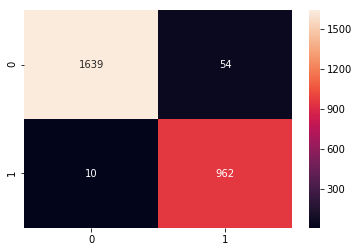

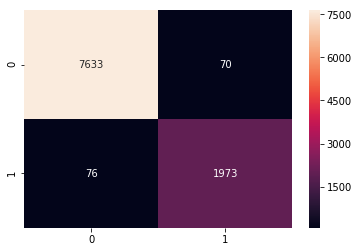

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from sklearn.feature_selection import SelectFromModel,SelectKBest,chi2,mutual_info_classif
from functools import partial
from sklearn.model_selection import cross_val_score

cv = StratifiedKFold(n_splits = 10, shuffle=True)
clf = Pipeline([
        ('scale', preprocessing.StandardScaler()),
        ('feature_selection', SelectFromModel(LinearSVC(C=0.1,penalty="l1",dual=False))),
        ('classification', RandomForestClassifier())
    ])
score = cross_val_score(clf, fm_train, data_y, cv=cv)
print("Mean validation score: {0:.3f} (std: {1:.5f})".format(np.mean(score),np.std(score)))
clf.fit(fm_train, data_y)

x_test, y_test = fm_test, vald_y
ac = accuracy_score(y_test,clf.predict(x_test))
print('Accuracy of test1 is: ', ac)
cm = confusion_matrix(y_test,clf.predict(x_test))
sns.heatmap(cm, annot=True, fmt="d")

plt.figure()
x_test, y_test = fm_test2, test_y
ac = accuracy_score(y_test,clf.predict(x_test))
print('Accuracy of test2 is: ', ac)
cm = confusion_matrix(y_test,clf.predict(x_test))
sns.heatmap(cm, annot=True, fmt="d")

%99 accuracy is easily matched with RF methods, however, in the literature we have seen less varianced accuracies with other ML methods. Let's save the dataframes here and search for a better approach with autoML (TPOT), semi-autoML with hyperparameter search. 

Part III: TPOT

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
from sklearn.preprocessing import scale
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations = 10 , population_size = 5, verbosity = 3)
tpot.fit(fm_train, data_y)

print("Test set one:")
print(tpot.score(fm_test, vald_y))

print("Test set two:")
print(tpot.score(fm_test2, test_y))

tpot.export('od_pipeline.py')

30 operators have been imported by TPOT.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False
Generation 1 - Current Pareto front scores:
-1	0.9884513333806509	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=True, LogisticRegression__penalty=l2)

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative
Generation 2 - Current Pareto front scores:
-1	0.9884513333806509	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=True, LogisticRegression__penalty=l2)

_pre_test decorator: _random_mutation_operator: num_te

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Average CV score on the training set was:0.9761803482741929
exported_pipeline = XGBClassifier(learning_rate=0.001, max_depth=3, min_child_weight=16, n_estimators=100, nthread=1, subsample=0.4)

exported_pipeline.fit(fm_train, data_y)
print(exported_pipeline.score(fm_test2, test_y))

0.9933347005742412
